# **Cassava Diseases Classification**

*by Dawei Fu, June 2021*

This dataset contain labelled images of cassava plants belonging to one of four disease categories or one category of good health. The task is to build a classifier that predicts in which of the five categories a new image should be. The dataset comes from this [Kaggle](https://www.kaggle.com/c/cassava-leaf-disease-classification/) competition.

I make use of transfer learning with a EfficientNet model pre-trained on ImageNet, and fine-tune it on this dataset. I code with TensorFlow and Keras, process data with numpy and pandas, and visualise them with matplotlib and OpenCV.

## I. Prepare data for training

In [1]:
# import libraries
import numpy as np
import pandas as pd
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import random
import cv2
import scipy as sp
import tensorflow as tf

# set random seed
seed = 42

In [2]:
# check data are loaded into the input directory
os.listdir('/kaggle/input/')

['cassava-leaf-disease-classification', 'model-weights']

In [3]:
# read csv file containing info on available data into a dataframe
images_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

# inspect first five entries
images_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
# shuffle the entries
images_df = images_df.sample(frac = 1, random_state = seed)
images_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


In [5]:
# create new column for paths to each image
train_folder = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
images_df['image_path'] = train_folder + images_df['image_id']
images_df.head()

,image_id,label,image_path
9134,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classificat...
1580,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
7304,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
13196,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...
5333,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...


In [6]:
# check total number of images
print(f'There are {len(images_df)} images available in total.')

There are 21397 images available in total


In [7]:
# check label to disease category mapping
dict_path = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
with open(dict_path, 'r') as j:
     label_dict = json.loads(j.read())

label_dict

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

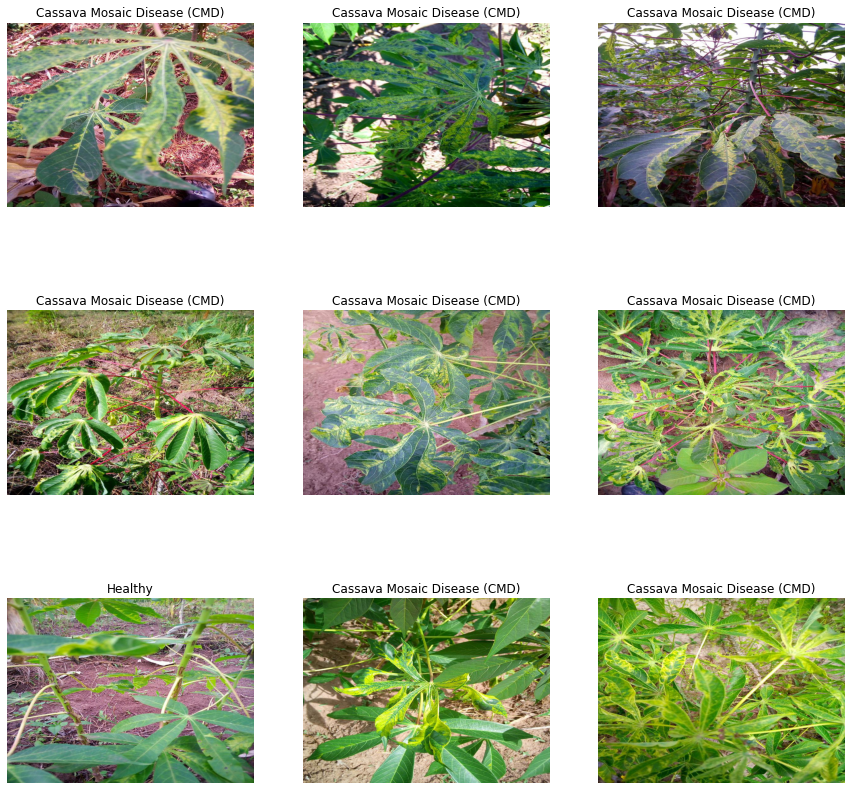

In [8]:
# check out 9 randomly selected images
images_to_display = images_df.sample(9)
plt.figure(figsize=(15, 15))
for i, (image_path, label) in enumerate(zip(images_to_display['image_path'],images_to_display['label'])):
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(label_dict[str(label)])
    plt.axis("off")

In [10]:
# define training set / validation set split
train_val_split = 0.9
train_count = int(len(images_df) * train_val_split)
val_count = int(len(images_df) * (1 - train_val_split))
print(f'Number of training samples: {train_count}')
print(f'Number of validation samples: {val_count}')

Number of training samples: 19257
Number of validation samples: 2139


In [11]:
# split into separate dataframes
train_images_df = images_df[:train_count]
val_images_df = images_df[train_count:]

<AxesSubplot:title={'center':'Training set'}, xlabel='Class', ylabel='# images'>

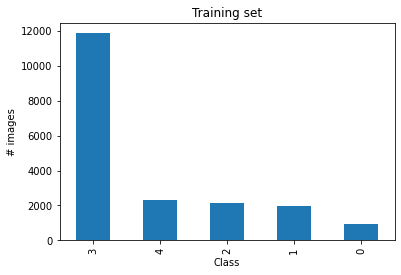

In [12]:
# plot class distribution of training set
train_images_df.label.value_counts().plot(kind = 'bar', 
                                        title = 'Training set', 
                                        xlabel = 'Class', 
                                        ylabel = '# images')

<AxesSubplot:title={'center':'Validation set'}, xlabel='Class', ylabel='# images'>

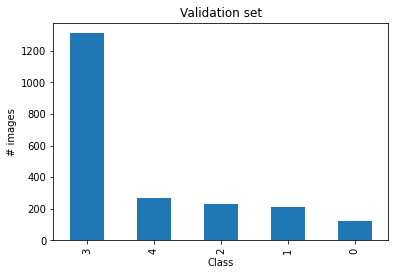

In [13]:
val_images_df.label.value_counts().plot(kind = 'bar', 
                                        title = 'Validation set', 
                                        xlabel = 'Class', 
                                        ylabel = '# images')

A note on the class distribution here. There is clearly a significant class imbalance. Class 3 has 6x as many data as Class 0, and Classes 1, 2, and 4 also have many fewer than Class 3. This imbalance will bias the classifier towards predicting Class 3 most of the time.

Common solutions to class imbalance include 1) collect more data for minority classes (duh!); 2) generate synthetic data for minority classes, e.g. with SMOTE or a GAN; 3) under-sample the majority class; 4) over-sample the minority classes; and 5) penalise the model more for mis-classifying minority classes. 

While there are more labelled images on the Internet that can be added to our training data, for fairness reasons we cannot do that. Synthetic data generation with images can take some effort to do properly, so save as last resort. Under-sampling involves throwing away data containing useful info, which might negatively impact the model's ability to learn the right features. Over-sampling risks over-fitting on duplicated data from the minority classes. 

### (Not used) Over-sample the minority classes

After experimentation, over-sampling and class weights both yielded worse perfomance for the majority class with no significant improvements on the minority classes. It seems the test set, to which we have no direct access to, follows the same class distribution as the training set, so it makes sense to train with this data as is.

In [14]:
# check the distribution again on minority classes
train_images_df[train_images_df['label'] != 3].label.value_counts()

4    2309
2    2157
1    1977
0     967
Name: label, dtype: int64

Class 0 is the fewest, at half as many as the other three minority classes

In [15]:
# create a subset of dublicated data
train_images_df_minority_oversample = pd.concat([pd.concat([train_images_df[train_images_df['label']==0]]*2),
                                               pd.concat([train_images_df[train_images_df['label']==1]]*1),
                                               pd.concat([train_images_df[train_images_df['label']==2]]*1),
                                               pd.concat([train_images_df[train_images_df['label']==4]]*1)])
train_images_df_minority_oversample.label.value_counts()

4    2309
2    2157
1    1977
0    1934
Name: label, dtype: int64

Balanced training set has 27634 images


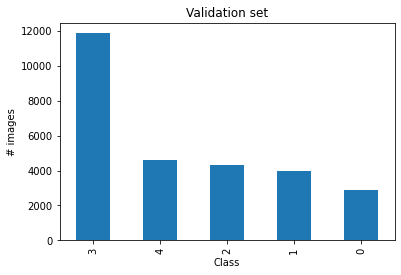

In [18]:
# concatenate over-sampled data with original training set
train_images_df_balanced = pd.concat([train_images_df, train_images_df_minority_oversample.sample(frac = 1, random_state = seed)])
train_images_df_balanced.label.value_counts().plot(kind = 'bar', 
                                                    title = 'Validation set', 
                                                    xlabel = 'Class', 
                                                    ylabel = '# images')
print(f'Balanced training set has {len(train_images_df_balanced)} images')

Now the minority classes have doubled number of examples as before, though still a fraction of Class 3. But at least the ratio is close to 3:1, which is fairly acceptable. 

In [23]:
# define training parameters
batch_size = 8
image_size = 600
input_shape = (image_size, image_size, 3)
dropout_rate = 0.5
classes_to_predict = np.sort(train_images_df['label'].unique())
print(classes_to_predict)

[0 1 2 3 4]


In [22]:
# create data set objects combining images (paths) and labels

# currently not using over-sampled data for training because experimentation showed suboptimal results
#train_data = tf.data.Dataset.from_tensor_slices((train_images_df_balanced['image path'].values, train_images_df_balanced['label'].values))
train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image_path'].values, train_images_df['label'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_images_df['image_path'].values, val_images_df['label'].values))

In [24]:
# allow auto-tuning of parallel calls for better perfomance 
autotune = tf.data.AUTOTUNE

# load each image from path
def load_image_and_label_from_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image, label

train_data = train_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)
val_data = val_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)

In [28]:
# create mini-batches for both training and validation sets
# training set is shuffled while validation set is not
train_data_batches = train_data.shuffle(buffer_size = 1000).batch(batch_size = batch_size).prefetch(buffer_size = autotune)
val_data_batches = val_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)
train_data_batches_for_eval = train_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [26]:
# create separate set for adapting first normalization layer in pre-trained model
def load_image_and_label_from_path_for_adapt(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    image = tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size)(image)
    return image

adapt_data = tf.data.Dataset.from_tensor_slices(train_images_df['image_path'].values)
adapt_data = adapt_data.map(load_image_and_label_from_path_for_adapt, num_parallel_calls = autotune)
adapt_data_batches = adapt_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

## II. Build model

We will use the EfficientNetB3 model as the backbone for feature extraction, since it's shown to be much more efficient than many other popular ones like ResNext while still being more accurate on many classification benchmarks, which is crucial because we are running on limited GPU allowance. The B3 version is also a good compromise between representation power and complexity.

We will attach some preprocessing layers before EfficientNet, and a few layers after as our classifier.

In [27]:
# stack a few common random preprocessing layers for data augmentation
augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.3)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.25)
], name = 'augmentation')

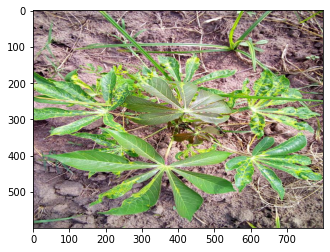

(800, 600)

In [30]:
# take a sample image to see what augmentations look like
preview = Image.open(images_df.iloc[1]['image_path'])
plt.imshow(preview)
plt.show()
preview.size

original image has shape (1, 600, 800, 3)
augmented image has shape (1, 600, 600, 3)


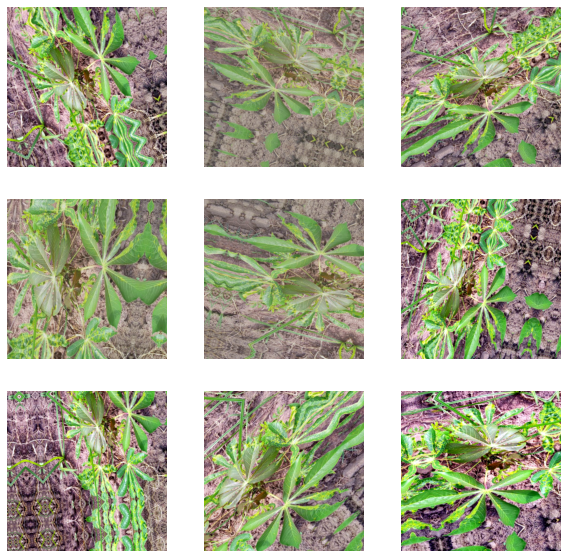

In [33]:
# run the sample image through the augmentation layers and display 9 random outputs
plt.figure(figsize=(10, 10))
image = tf.expand_dims(np.array(preview), 0)
print(f'original image has shape {image.shape}')
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_layers(image)
    plt.imshow(augmented_image[0])
    #plt.title(int(label))
    plt.axis("off")
print(f'augmented image has shape {augmented_image.shape}')

In [34]:
# load EfficientNetB3 without the top classification layers
from tensorflow.keras.applications import EfficientNetB3
model = EfficientNetB3(weights = 'imagenet',
                       include_top = False,
                       drop_connect_rate = 0.5,
                       input_shape = input_shape)

43941888/43941136 [==============================] - 0s 0us/step


In [35]:
# check the architecture of the base model
model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# first freeze all the parameters of the base model
model.trainable = False

In [36]:
# build final model with extra layers before and after the base model
def build_model(base_model):
    inputs = tf.keras.layers.Input(shape = input_shape, name = 'input')
    x = augment_layers(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name = 'gap')(x)
    x = tf.keras.layers.Dropout(dropout_rate, name = 'drop')(x)
    outputs = tf.keras.layers.Dense(len(classes_to_predict), activation = 'softmax', name = 'dense')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [37]:
final_model = build_model(model)

In [38]:
# check the final model
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 600, 3)]     0         
_________________________________________________________________
augmentation (Sequential)    (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 19, 19, 1536)      10783535  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1536)              0         
_________________________________________________________________
drop (Dropout)               (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [ ]:
# adapt the normalization layer on the prepared data
final_model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

## III. Train model

I first freeze all layers in the base model and train the new classification layers. The new layers have randomly initialsed weights so the first few epochs will generate huge loss, which might mess up the pre-trained layers if not frozen. 

When the new layers stop improving after a few epochs, I unfreeze the base model and fine tune all layers again with reduced learning rates. 

In [39]:
# set number of epochs and callbacks parameters
epochs = 5
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                             patience = 3,
                                             verbose = 1),
             tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5',
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only = True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.3,
                                                 patience=2,
                                                 mode = 'min',
                                                 verbose = 1)]

# use Adam as optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

# use Sparse Categorical Cross-entropy as loss function because this is multi-class classification
# not using Categorical Cross-entropy because the labels are not one-hot vectors but strings instead
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# class weights can selectively penalise mistakes on certain classes but turned out to not help much
class_weights = {0 : 1,
                1 : 1,
                2 : 1,
                3 : 1,
                4 : 1}

final_model.compile(loss = loss_function,
                   optimizer = optimizer,
                   metrics = ['acc'])

In [ ]:
# tea time!
hist = final_model.fit(train_data_batches,
                      epochs = epochs,
                      validation_data = val_data_batches,
                      callbacks = callbacks,
                      class_weight = class_weights)

In [ ]:
# unfreeze all the layers
final_model.trainable = True

In [ ]:
# fine tune the entire model with decreasing learning rate until validation loss levels off
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
hist = final_model.fit(train_data_batches,
                      epochs = epochs,
                      validation_data = val_data_batches,
                      callbacks = callbacks,
                      class_weight = class_weights)

In [ ]:
# load the best weights with lowest val_loss
final_model.load_weights("../input/model-weights/Checkpoint_val_loss_0p361.h5")

In [ ]:
# plot losses vs epoch
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
# plot accuracy vs epoch
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

The plots are not shown because I trained over many notebook instances.

In [ ]:
# generate predictions on validation set for error analysis
val_predict = final_model.predict(val_data_batches, verbose = 1)
val_y = np.argmax(val_predict, axis=1)

In [ ]:
# generate confusion matrix and classification report with sklearn
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(val_images_df.label.values, val_y))

In [ ]:
print(classification_report(val_images_df.label.values, val_y))

In [ ]:
print(confusion_matrix(train_images_df_balanced.label.values, train_y))

In [ ]:
print(classification_report(train_images_df_balanced.label.values, train_y))

In [ ]:
print(confusion_matrix(val_images_df.label.values, val_y))

In [ ]:
print(classification_report(val_images_df.label.values, val_y))

In [ ]:
gap_weights = final_model.layers[-1].get_weights()[0]
print(gap_weights.shape)

cam_model  = tf.keras.Model(inputs=final_model.input,outputs=(final_model.layers[-3].input,final_model.layers[-1].output))
cam_model.summary()

In [ ]:
def show_cam(image, features, results, label):
    
    '''
    Displays the class activation map of an image

    Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
    '''

    # there is only one image in the batch so we index at `0`
    features_for_img = features[0]
    pred_label = np.argmax(results[0], axis = 0)

    # there is only one unit in the output so we get the weights connected to it
    class_activation_weights = gap_weights[:,0]

    # upsample to the image size
    class_activation_features = sp.ndimage.zoom(features_for_img, (600/19, 600/19, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    cam_output = cam_output * 2
    cam_output = np.clip(cam_output, 0, 255).astype(np.uint8)
    cam_output = cv2.applyColorMap(cam_output, cv2.COLORMAP_HOT)

    super_imposed_image = cv2.addWeighted(np.squeeze(image.astype('float32'), axis = 0), 0.0025, 
                                          cam_output.astype('float32'), 0.003, 0.0)
    #print(cam_output)
    #print(super_imposed_image)
    print(f'softmax output: {results}')
    f,ax = plt.subplots(1,3, figsize=(8,15))

    ax[0].imshow(np.squeeze(image, axis = 0))
    ax[0].set_title(f"True label: {label} \n Predicted label: {pred_label}")
    ax[0].axis('off')

    ax[1].imshow(cam_output)
    ax[1].set_title("Class Activation Map")
    ax[1].axis('off')

    ax[2].imshow(super_imposed_image)
    ax[2].set_title("Activation map superimposed")
    ax[2].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(index):

    # load the image
    image = Image.open(val_images_df.iloc[index]['image path'])
    
    # preprocess the image before feeding it to the model
    image_cropped = tf.image.random_crop(np.array(image), input_shape)
    
    # add a batch dimension because the model expects it
    image_processed = np.expand_dims(image_cropped, axis=0)
    
    label = val_images_df.iloc[index]['label']

    # get the features and prediction
    features,results = cam_model.predict(image_processed)

    # generate the CAM
    show_cam(image_processed, features, results, label)

In [ ]:
index = 0

for index in range(20):
    convert_and_classify(index)